In [50]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
import cv2 as cv2
from PIL import Image
import os
import re
import json
from tqdm import tqdm
import pyocr
!rm -rf ~/.cache/matplotlib
import networkx as nx
import japanize_matplotlib 
 

In [19]:
path =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/Org_chart/cropped/"
path_json =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/Org_chart/output/"
path_clean = "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/Org_chart/clean/"
files_json = os.listdir(path_json)
files_json = [f for f in files_json if os.path.isfile(os.path.join(path_json, f))]

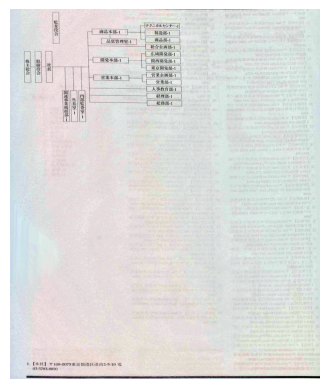

findfont: Font family 'Hiragino Kaku Gothic Pro' not found.
findfont: Font family 'Hiragino Kaku Gothic Pro' not found.
findfont: Font family 'Hiragino Kaku Gothic Pro' not found.
findfont: Font family 'Hiragino Kaku Gothic Pro' not found.
findfont: Font family 'Hiragino Kaku Gothic Pro' not found.


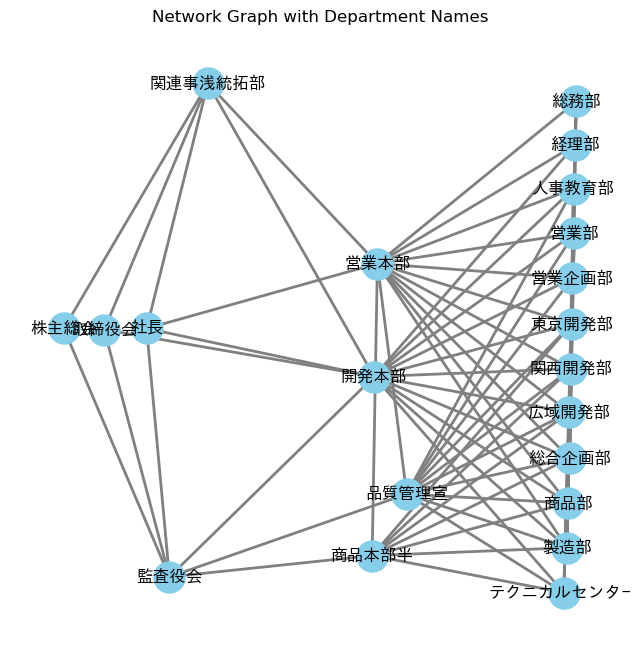

In [62]:
i = 8
file_json = os.path.join(path_json, files_json[i])
with open(file_json, "r") as f:
    data = json.load(f)
file = path + data["file_name"][-13:]
image_cv = cv2.imread(file)
image_width, image_height = image_cv.shape[:2] 

centers = []  
dept_names = {}  
tools = pyocr.get_available_tools()
tool = tools[0]

for idx, box in enumerate(data["pred_boxes"]):
    x_min, y_min, x_max, y_max = map(int, box)
    cropped = image_cv[y_min:y_max, x_min:x_max]
    gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    pil_image = Image.fromarray(gray_image)
    height, width = gray_image.shape[:2]
    if height < width:
        txt = tool.image_to_string(
            pil_image,
            lang="jpn",
            builder=pyocr.builders.TextBuilder(tesseract_layout=6)
        )
    else:
        txt = tool.image_to_string(
            pil_image,
            lang="jpn_vert",
            builder=pyocr.builders.TextBuilder(tesseract_layout=5)
        )
    result = re.sub(r"[^\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]", "", txt)
    if not result:
        continue
    x_center = int((box[0] + box[2]) / 2)
    y_center = int((box[1] + box[3]) / 2)
    x_normalized = (x_center / image_width) * 10
    y_normalized = (y_center / image_height) * 10
    centers.append({"id": idx, "center": (x_normalized, y_normalized)})
    dept_names[idx] = result

G = nx.Graph()

for center in centers:
    node_id = center["id"]
    G.add_node(node_id, pos=center["center"], label=dept_names.get(node_id, ""))

distance_threshold_lower = 1
distance_threshold_upper = 2
for i in range(len(centers)):
    for j in range(i + 1, len(centers)):
        dist = np.linalg.norm(np.array(centers[i]["center"]) - np.array(centers[j]["center"]))
        if distance_threshold_lower < dist < distance_threshold_upper:
            G.add_edge(centers[i]["id"], centers[j]["id"], weight=dist)

pos = nx.get_node_attributes(G, "pos")
plt.imshow(image_cv)
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

node_labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12,font_family="IPAexGothic")

plt.title("Network Graph with Department Names")
plt.axis('off')
plt.show()


In [63]:
G